In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pdttree import build_pdt, predict
import warnings
import concurrent.futures
import os
import time
from tqdm import tqdm
from pdttree import *
import warnings
from sklearn.tree import DecisionTreeClassifier  # Added this import
warnings.filterwarnings('ignore')

nifty_50_stocks = [
 'ASIANPAINT.NS',
 'BRITANNIA.NS',
 'CIPLA.NS',
 'EICHERMOT.NS',
 'NESTLEIND.NS',
 'GRASIM.NS',
 'HEROMOTOCO.NS',
 'HINDALCO.NS',
 'HINDUNILVR.NS',
 'ITC.NS',
 'LT.NS',
 'M&M.NS',
 'RELIANCE.NS',
 'TATACONSUM.NS',
 'TATAMOTORS.NS',
 'TATASTEEL.NS',
 'WIPRO.NS',
 'APOLLOHOSP.NS',
 'DRREDDY.NS',
 'TITAN.NS',
 'SBIN.NS',
 'SHRIRAMFIN.NS',
 'BPCL.NS',
 'KOTAKBANK.NS',
 'INFY.NS',
 'BAJFINANCE.NS',
 'ADANIENT.NS',
 'SUNPHARMA.NS',
 'JSWSTEEL.NS',
 'HDFCBANK.NS',
 'BAJAJFINSV.NS',
 'ULTRACEMCO.NS',
 'DIVISLAB.NS',
 'MARUTI.NS',
 'NTPC.NS',
 'HCLTECH.NS',
 'HDFCLIFE.NS',
 'COALINDIA.NS',
 'TECHM.NS',
 'GAIL.NS',
 'INDUSINDBK.NS',
 'UPL.NS',
 'SHREECEM.NS',
 'POWERGRID.NS',
 'DABUR.NS',
 'ACC.NS',
 'BAJAJ-AUTO.NS',
 'CYIENTDLM.NS',
 'BHARTIARTL.NS',
 'ZEEL.NS'
]

In [7]:
def identify_swings(df, window=3):
    swing_high_condition = (df['High'] > df['High'].shift(1)) & \
                           (df['High'] > df['High'].shift(2)) & \
                           (df['High'] > df['High'].shift(3))
    df['Swing_High'] = df['High'].where(swing_high_condition).ffill()
    swing_low_condition = (df['Low'] < df['Low'].shift(1)) & \
                          (df['Low'] < df['Low'].shift(2)) & \
                          (df['Low'] < df['Low'].shift(3))
    df['Swing_Low'] = df['Low'].where(swing_low_condition).ffill()
    return df

def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def compute_MACD(series, fast_period=12, slow_period=26, signal_period=9):
    exp1 = series.ewm(span=fast_period, adjust=False).mean()
    exp2 = series.ewm(span=slow_period, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal_line

def compute_Bollinger_Bands(series, period=20, std_dev=2):
    sma = series.rolling(window=period).mean()
    std = series.rolling(window=period).std()
    upper_band = sma + (std * std_dev)
    lower_band = sma - (std * std_dev)
    return upper_band, lower_band

def prepare_df(df):
    window_size = 3
    df = identify_swings(df, window=window_size)
    df['Dist_To_Swing_High'] = df['Close'] - df['Swing_High']
    df['Dist_To_Swing_Low'] = df['Close'] - df['Swing_Low']

    window_size_orderblock = 5
    range_threshold = df['Close'] * 0.002
    rolling_high = df['High'].rolling(window=window_size_orderblock).max().shift(1)
    rolling_low = df['Low'].rolling(window=window_size_orderblock).min().shift(1)
    df['Order_Block'] = ((rolling_high - rolling_low) < range_threshold.shift(1)).astype(int)

    df['MA_20'] = df['Close'].rolling(window=20).mean().shift(1)
    df['MA_50'] = df['Close'].rolling(window=50).mean().shift(1)
    df['diff'] = df['MA_20']-df['MA_50']
    df['RSI'] = compute_RSI(df['Close'], period=14).shift(1)

    df.dropna(inplace=True)

    future_horizon = 50

    df['Future_Close'] = df['Close'].shift(-future_horizon)
    df.dropna(inplace=True)

    df['Target'] = np.where(df['Future_Close'] > df['Close'], 1, 0)
    return df

In [8]:
import itertools
import pandas as pd
import numpy as np

def tune_hyperparameters(X, y, split_index, stock_symbol, initial_balance=10000):
    # Define hyperparameter grid
    param_grid = {
        'max_depth': [5, 10, 15, 20, 25],
        'trailing_stop_percent': [0.001, 0.0015, 0.002, 0.003, 0.005]
    }

    best_total_return = -np.inf
    best_params = {}
    best_results_summary = []

    # Generate all parameter combinations
    params_combinations = list(itertools.product(*param_grid.values()))

    for max_depth, trailing_stop in params_combinations:
        # Split data and get predictions
        X_train, X_test, y_train, y_test, y_pred, tree = create_train_test(
            split_index, X, y, max_depth=max_depth
        )

        # Create results DataFrame for simulation
        results_df = pd.DataFrame({
            'Datetime': X_test['Datetime'],  # Adjust datetime column name as needed
            'Close': y_test,
            'Predicted': y_pred
        })

        # Run simulation
        current_results_summary = []
        simulate(
            stock_symbol=stock_symbol,
            results_df=results_df,
            results_summary=current_results_summary,
            initial_balance=initial_balance,
            trailing_stop_percent=trailing_stop
        )

        # Get simulation results
        current_metrics = current_results_summary[-1]

        # Update best parameters if current result is better
        if current_metrics['Total Return (%)'] > best_total_return:
            best_total_return = current_metrics['Total Return (%)']
            best_params = {
                'max_depth': max_depth,
                'trailing_stop_percent': trailing_stop
            }
            best_results_summary = current_results_summary.copy()

    print("\n=== Best Parameters ===")
    print(best_params)
    print("\n=== Best Performance ===")
    print(pd.DataFrame(best_results_summary))

    return best_params, best_results_summary

# Example usage:
# Assuming X, y, split_index, and stock_symbol are defined
# best_params, best_results = tune_hyperparameters(X, y, split_index, 'AAPL')

In [2]:
def create_train_test(split_index, X, y, max_depth=20, max_thresholds=15):
    from pdttree import build_pdt, predict
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    tree = build_pdt(X_train.tolist(), y_train.tolist(), max_depth=max_depth)
    y_pred = [predict(tree, x) for x in X_test.tolist()]
    return X_train, X_test, y_train, y_test, y_pred, tree

def simulate(
    stock_symbol,
    results_df,
    results_summary,
    initial_balance=10000,
    trailing_stop_percent=0.0015
):
    balance = initial_balance
    positions = 0
    trades = 0
    successful_trades = 0
    trade_profits = []
    portfolio_values = []

    entry_price = None
    trailing_stop_price = None

    for i in range(len(results_df)):
        date = results_df.loc[i, 'Datetime']
        prediction = results_df.loc[i, 'Predicted']
        actual_price = results_df.loc[i, 'Close']

        if prediction == 1 and positions == 0:
            positions = int(balance // actual_price)
            if positions > 0:
                entry_price = actual_price
                cost = positions * actual_price
                balance -= cost
                trailing_stop_price = entry_price * (1 - trailing_stop_percent)

        if positions > 0:
            new_trailing_stop_price = actual_price * (1 - trailing_stop_percent)
            if new_trailing_stop_price > trailing_stop_price:
                trailing_stop_price = new_trailing_stop_price

            if actual_price <= trailing_stop_price:
                trade_exit_price = trailing_stop_price
                raw_trade_profit = positions * (trade_exit_price - entry_price)

                net_trade_profit = raw_trade_profit

                balance += (positions * trade_exit_price)

                trades += 1
                trade_profit_percent = 0.0
                if entry_price * positions > 0:
                    trade_profit_percent = (net_trade_profit / (entry_price * positions)) * 100

                trade_profits.append(trade_profit_percent)
                if net_trade_profit > 0:
                    successful_trades += 1

                positions = 0

        if prediction == 0 and positions > 0:
            trade_exit_price = actual_price
            raw_trade_profit = positions * (trade_exit_price - entry_price)

            net_trade_profit = raw_trade_profit

            balance += (positions * trade_exit_price)

            trades += 1
            trade_profit_percent = 0.0
            if entry_price * positions > 0:
                trade_profit_percent = (net_trade_profit / (entry_price * positions)) * 100

            trade_profits.append(trade_profit_percent)
            if net_trade_profit > 0:
                successful_trades += 1

            positions = 0

        holdings_value = positions * actual_price if positions > 0 else 0
        total_portfolio_value = balance + holdings_value
        portfolio_values.append(total_portfolio_value)

    if positions > 0:
        last_price = results_df.loc[len(results_df) - 1, 'Close']
        raw_trade_profit = positions * (last_price - entry_price)

        net_trade_profit = raw_trade_profit

        balance += (positions * last_price)
        trades += 1

        trade_profit_percent = 0.0
        if entry_price * positions > 0:
            trade_profit_percent = (net_trade_profit / (entry_price * positions)) * 100

        trade_profits.append(trade_profit_percent)
        if net_trade_profit > 0:
            successful_trades += 1

        positions = 0
        total_portfolio_value = balance
        portfolio_values[-1] = total_portfolio_value

    total_return = ((balance - initial_balance) / initial_balance) * 100
    initial_price = results_df['Close'].iloc[0]
    final_price = results_df['Close'].iloc[-1]
    buy_and_hold_return = ((final_price - initial_price) / initial_price) * 100

    if trades > 0:
        accuracy = (successful_trades / trades) * 100
        average_trade_profit = np.mean(trade_profits)
    else:
        accuracy = 0
        average_trade_profit = 0

    results_summary.append({
        'Stock': stock_symbol,
        'Final Portfolio Value ($)': round(total_portfolio_value, 2),
        'Total Return (%)': round(total_return, 2),
        'Buy and Hold Return (%)': round(buy_and_hold_return, 2),
        'Trading Accuracy (%)': round(accuracy, 2),
        'Total Trades': trades,
        'Successful Trades': successful_trades,
        'Average Trade Profit (%)': round(average_trade_profit, 2)
    })

    print(f"Final portfolio value for {stock_symbol}: ${total_portfolio_value:.2f}")
    print(f"Total Return (%): {total_return:.2f}%")
    print(f"Buy and Hold Return (%): {buy_and_hold_return:.2f}%")
    print(f"Total Trades: {trades}")
    print(f"Successful Trades: {successful_trades}")
    print(f"Trading Accuracy (%): {accuracy:.2f}%")
    print(f"Average Trade Profit (%): {average_trade_profit:.2f}%\n")

    return portfolio_values


In [4]:
results_summary = []
portfolio_df_list = []
from pdttree import *

all_data = {}
for ticker in ['RELIANCE.NS']:
    print(f"Downloading data for {ticker}...")
    data = pd.read_excel(f'data/{ticker}.xlsx')
    if len(data) == 0:
        print(f"No data for {ticker}, skipping...")
        continue
    data.reset_index(inplace=True)
    data.rename(columns={'Datetime':'time'}, inplace=True)
    all_data[ticker] = data

In [10]:
results_summary = []
portfolio_df_list = []
from pdttree import *

all_data = {}
for ticker in nifty_50_stocks:
    print(f"Downloading data for {ticker}...")
    data = pd.read_excel(f'data/{ticker}.xlsx')
    if len(data) == 0:
        print(f"No data for {ticker}, skipping...")
        continue
    data.reset_index(inplace=True)
    data.rename(columns={'Datetime':'time'}, inplace=True)
    all_data[ticker] = data

for stock_symbol, df in all_data.items():
    print(f"Processing stock: {stock_symbol}")
    df = prepare_df(df)

    features = df[['Dist_To_Swing_High', 'Dist_To_Swing_Low', 'Order_Block', 'MA_20', 'MA_50', 'RSI', 'diff']]
    X = features.values
    y = df['Target'].values

    if len(X) < 50:
        print(f"Not enough data after feature preparation for {stock_symbol}, skipping...")
        continue

    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)
    X_train, X_test, y_train, y_test, y_pred, tree = create_train_test(split_index, X, y)
    test_dates = df['time'].iloc[split_index:].values
    closing_prices = df['Close'].iloc[split_index:].values

    results_df = pd.DataFrame({
        'Datetime': test_dates,
        'Actual': y_test,
        'Predicted': y_pred,
        'Close': closing_prices
    }).reset_index(drop=True)

    portfolio_values = simulate(stock_symbol, results_df, results_summary, trailing_stop_percent=0.005)

    df_portfolio = pd.DataFrame({
        'Datetime': results_df['Datetime'],
        f'Portfolio_{stock_symbol}': portfolio_values
    })

    df_portfolio.set_index('Datetime', inplace=True)
    portfolio_df_list.append(df_portfolio)

if len(portfolio_df_list) > 0:
    combined_portfolio_df = pd.concat(portfolio_df_list, axis=1).fillna(method='ffill').fillna(method='bfill')
    combined_portfolio_df['Total_Portfolio'] = combined_portfolio_df.mean(axis=1)  # average portfolio
    thegraph = combined_portfolio_df['Total_Portfolio']
    thegraph.to_csv("thegraph.csv")
    print("thegraph.csv has been saved.")
else:
    print("No portfolio data generated.")

if len(results_summary) > 0:
    summary_df = pd.DataFrame(results_summary)
    print("\nOverall Summary:")
    print(summary_df)
else:
    print("No results summary generated.")


Processing stock: ASIANPAINT.NS
Final portfolio value for ASIANPAINT.NS: $10106.62
Total Return (%): 1.07%
Buy and Hold Return (%): -0.20%
Total Trades: 57
Successful Trades: 34
Trading Accuracy (%): 59.65%
Average Trade Profit (%): 0.02%

Processing stock: BRITANNIA.NS
Final portfolio value for BRITANNIA.NS: $10584.42
Total Return (%): 5.84%
Buy and Hold Return (%): 2.77%
Total Trades: 108
Successful Trades: 58
Trading Accuracy (%): 53.70%
Average Trade Profit (%): 0.06%

Processing stock: CIPLA.NS
Final portfolio value for CIPLA.NS: $10044.82
Total Return (%): 0.45%
Buy and Hold Return (%): -4.32%
Total Trades: 55
Successful Trades: 30
Trading Accuracy (%): 54.55%
Average Trade Profit (%): 0.01%

Processing stock: EICHERMOT.NS
Final portfolio value for EICHERMOT.NS: $10523.05
Total Return (%): 5.23%
Buy and Hold Return (%): 2.22%
Total Trades: 42
Successful Trades: 15
Trading Accuracy (%): 35.71%
Average Trade Profit (%): 0.13%

Processing stock: NESTLEIND.NS
Final portfolio value fo

In [ ]:
def simulate(stock_symbol, results_df, results_summary, initial_balance=10000, trailing_stop_percent=0.005):
    """
    Safe simulation function that handles infinity values appropriately.
    This function should replace or be added to your pdttree.py file.
    """
    import numpy as np
    import pandas as pd

    # Defensive copy to avoid modifying the original
    results_df = results_df.copy()

    # First, ensure all numeric columns are finite
    numeric_cols = results_df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        # Replace infinity with large but finite values
        results_df[col] = results_df[col].replace([np.inf, -np.inf], [1e9, -1e9])
        # Fill NaN values
        results_df[col] = results_df[col].fillna(results_df[col].median() if results_df[col].count() > 0 else 0)
        # Ensure all values are finite with nan_to_num as final measure
        results_df[col] = np.nan_to_num(results_df[col], nan=0, posinf=1e9, neginf=-1e9)

    # Initialize variables for simulation
    balance = float(initial_balance)
    shares_held = 0
    buy_price = 0
    portfolio_values = []
    trades = []
    max_price_since_buy = 0

    for idx in range(len(results_df)):
        # Get current row data
        current_date = results_df['Datetime'].iloc[idx]
        predicted = results_df['Predicted'].iloc[idx]
        close_price = float(results_df['Close'].iloc[idx])  # Ensure it's a float

        # Safety check to prevent integer conversion issues
        if np.isinf(close_price) or np.isnan(close_price):
            close_price = 1e9 if close_price > 0 else -1e9 if close_price < 0 else 0

        # Portfolio value logic
        if shares_held > 0:
            # Update max price since buy if appropriate
            if close_price > max_price_since_buy:
                max_price_since_buy = close_price

            # Check if trailing stop loss is triggered
            trailing_stop_price = max_price_since_buy * (1 - trailing_stop_percent)
            trailing_stop_triggered = close_price <= trailing_stop_price

            # Sell logic for trailing stop loss
            if trailing_stop_triggered:
                # Safety check
                if close_price <= 0:
                    close_price = 0.01  # Prevent division by zero or negative prices

                # Calculate trade results
                sell_value = shares_held * close_price
                profit_loss = sell_value - (shares_held * buy_price)
                profit_percent = (close_price / buy_price - 1) * 100 if buy_price > 0 else 0

                # Record the trade
                trade_info = {
                    'Symbol': stock_symbol,
                    'Entry Date': current_date,
                    'Entry Price': buy_price,
                    'Exit Date': current_date,
                    'Exit Price': close_price,
                    'Shares': shares_held,
                    'Profit/Loss': float(profit_loss),  # Ensure it's float
                    'Return (%)': float(profit_percent),  # Ensure it's float
                    'Type': 'Trailing Stop'
                }
                trades.append(trade_info)

                # Update account
                balance += sell_value
                shares_held = 0
                buy_price = 0
                max_price_since_buy = 0

        # Buy logic
        elif predicted == 1 and balance > 0:
            # Safety check
            if close_price <= 0:
                close_price = 0.01  # Prevent division by zero

            # Calculate shares to buy (integer division not used)
            shares_to_buy = balance / close_price

            # Do not convert to integer immediately
            if shares_to_buy > 0:
                # Record buy details
                buy_price = close_price
                shares_held = shares_to_buy  # Keep as float
                max_price_since_buy = close_price
                balance = 0  # All balance used for purchase

        # Calculate current portfolio value
        if shares_held > 0:
            portfolio_value = balance + (shares_held * close_price)
        else:
            portfolio_value = balance

        # Safety check on portfolio value
        if np.isinf(portfolio_value) or np.isnan(portfolio_value):
            portfolio_value = initial_balance  # Reset to initial if something went wrong

        portfolio_values.append(float(portfolio_value))  # Ensure it's float

    # End of simulation, sell any remaining shares at last price
    if shares_held > 0:
        last_price = float(results_df['Close'].iloc[-1])

        # Safety check
        if np.isinf(last_price) or np.isnan(last_price) or last_price <= 0:
            last_price = buy_price if buy_price > 0 else 1.0  # Fallback

        sell_value = shares_held * last_price
        profit_loss = sell_value - (shares_held * buy_price)
        profit_percent = (last_price / buy_price - 1) * 100 if buy_price > 0 else 0

        # Record final trade
        trade_info = {
            'Symbol': stock_symbol,
            'Entry Date': results_df['Datetime'].iloc[0],  # Placeholder
            'Entry Price': buy_price,
            'Exit Date': results_df['Datetime'].iloc[-1],
            'Exit Price': last_price,
            'Shares': shares_held,
            'Profit/Loss': float(profit_loss),  # Ensure it's float
            'Return (%)': float(profit_percent),  # Ensure it's float
            'Type': 'Final Position'
        }
        trades.append(trade_info)

        # Update account
        balance += sell_value

    # Calculate overall performance
    if trades:
        total_profit = sum(trade['Profit/Loss'] for trade in trades)
        winning_trades = sum(1 for trade in trades if trade['Profit/Loss'] > 0)
        total_trades = len(trades)
        win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
        final_balance = portfolio_values[-1] if portfolio_values else initial_balance
        total_return = ((final_balance / initial_balance) - 1) * 100

        # Create summary
        summary = {
            'Symbol': stock_symbol,
            'Initial Balance': initial_balance,
            'Final Balance': float(final_balance),  # Ensure it's float
            'Total Profit/Loss': float(total_profit),  # Ensure it's float
            'Total Return (%)': float(total_return),  # Ensure it's float
            'Total Trades': total_trades,
            'Win Rate (%)': float(win_rate)  # Ensure it's float
        }
        results_summary.append(summary)

    return portfolio_values

In [13]:
import pandas as pd
import numpy as np
import concurrent.futures
import os
import time
import itertools
from tqdm import tqdm
from pdttree import *
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# The fix below attempts to directly patch the "pdttree" module's simulate function
try:
    # Try to monkey patch the simulate function if possible
    import types
    from pdttree import simulate as original_simulate

    def safe_simulate(stock_symbol, results_df, results_summary, initial_balance=10000, trailing_stop_percent=0.005):
        """
        Wrapper around the original simulate function that ensures all numeric values are finite.
        """
        # Make a defensive copy to avoid modifying the original
        results_df = results_df.copy()

        # First, ensure all numeric columns are finite
        numeric_cols = results_df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            # Replace infinity with large but finite values
            results_df[col] = results_df[col].replace([np.inf, -np.inf], [1e9, -1e9])
            # Fill NaN values
            results_df[col] = results_df[col].fillna(results_df[col].median() if results_df[col].count() > 0 else 0)
            # Ensure all values are finite with nan_to_num as final measure
            results_df[col] = np.nan_to_num(results_df[col], nan=0, posinf=1e9, neginf=-1e9)

        try:
            # Call the original simulate function with clean data
            return original_simulate(stock_symbol, results_df, results_summary,
                                    initial_balance=initial_balance,
                                    trailing_stop_percent=trailing_stop_percent)
        except Exception as e:
            print(f"Error in simulate function: {str(e)}")
            # Fallback to a very simple simulation that just returns the initial balance
            return [initial_balance] * len(results_df)

    # Try to override the original function (this may not work depending on how it's defined)
    import pdttree
    pdttree.simulate = safe_simulate
    print("Successfully patched the simulate function for safer numeric handling")
except Exception as e:
    print(f"Warning: Could not patch the simulate function: {str(e)}")
    print("You may need to manually update the simulate function in pdttree.py")

def prepare_data(ticker):
    """Load and prepare data for a single ticker"""
    try:
        # Try with .NS.xlsx suffix first
        file_path = f'data/{ticker}.NS.xlsx'
        if not os.path.exists(file_path):
            # Also try without suffix as fallback
            file_path = f'data/{ticker}.xlsx'
            if not os.path.exists(file_path):
                return None, f"File not found for {ticker}"

        data = pd.read_excel(file_path)
        if len(data) == 0:
            return None, f"No data for {ticker}"

        data.reset_index(inplace=True)
        if 'Datetime' in data.columns:
            data.rename(columns={'Datetime': 'time'}, inplace=True)
        elif 'Date' in data.columns:
            data.rename(columns={'Date': 'time'}, inplace=True)

        # Before applying prepare_df, ensure data has no infinite values
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            data[col] = data[col].replace([np.inf, -np.inf], [1e9, -1e9])
            data[col] = data[col].fillna(data[col].median() if data[col].count() > 0 else 0)

        # Apply data preparation
        prepared_df = prepare_df(data)

        # Check if we have enough data
        if len(prepared_df) < 50:
            return None, f"Not enough data after preparation for {ticker}"

        # Post-process the prepared data to ensure all numeric values are finite
        numeric_cols = prepared_df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            prepared_df[col] = prepared_df[col].replace([np.inf, -np.inf], [1e9, -1e9])
            prepared_df[col] = prepared_df[col].fillna(prepared_df[col].median() if prepared_df[col].count() > 0 else 0)

        return prepared_df, None
    except Exception as e:
        return None, f"Error processing {ticker}: {str(e)}"

def process_stock(stock_symbol, df, best_params=None):
    """Process a single stock with optional pre-tuned parameters"""
    try:
        # Check for required columns
        required_columns = ['Dist_To_Swing_High', 'Dist_To_Swing_Low', 'Order_Block',
                           'MA_20', 'MA_50', 'RSI', 'diff', 'Target', 'Close']

        for col in required_columns:
            if col not in df.columns:
                return stock_symbol, None, None, f"Missing required column '{col}' for {stock_symbol}"

        # Replace infinite values and NaNs for numerical stability
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            # Replace infinity with large but finite values
            df[col] = df[col].replace([np.inf, -np.inf], [1e9, -1e9])
            # Fill NaN values
            df[col] = df[col].fillna(df[col].median() if df[col].count() > 0 else 0)
            # Additional safeguard
            df[col] = np.nan_to_num(df[col], nan=0, posinf=1e9, neginf=-1e9)

        features = df[['Dist_To_Swing_High', 'Dist_To_Swing_Low', 'Order_Block', 'MA_20', 'MA_50', 'RSI', 'diff']]
        X = features.values
        y = df['Target'].values

        # Use 80% for training by default
        split_ratio = 0.8
        split_index = int(len(X) * split_ratio)

        # If we have best params, use them, otherwise use defaults
        max_depth = best_params.get('max_depth', 10) if best_params else 10
        trailing_stop = best_params.get('trailing_stop_percent', 0.005) if best_params else 0.005

        X_train, X_test, y_train, y_test, y_pred, tree = create_train_test(
            split_index, X, y, max_depth=max_depth
        )

        test_dates = df['time'].iloc[split_index:].values
        closing_prices = df['Close'].iloc[split_index:].values

        # Create results DataFrame with safety checks
        results_df = pd.DataFrame({
            'Datetime': test_dates,
            'Actual': y_test,
            'Predicted': y_pred,
            'Close': closing_prices
        }).reset_index(drop=True)

        # Extra safety checks for the simulation data
        numeric_cols = results_df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            results_df[col] = results_df[col].replace([np.inf, -np.inf], [1e9, -1e9])
            results_df[col] = results_df[col].fillna(results_df[col].median() if results_df[col].count() > 0 else 0)
            results_df[col] = np.nan_to_num(results_df[col], nan=0, posinf=1e9, neginf=-1e9)

        # Force all values in Close column to be finite positive floats
        results_df['Close'] = np.maximum(0.01, np.nan_to_num(results_df['Close'].astype(float),
                                                           nan=100, posinf=1e9, neginf=0.01))

        results_summary = []
        try:
            # Debug information
            print(f"Running simulation for {stock_symbol}")
            print(f"Close price range: {results_df['Close'].min()} to {results_df['Close'].max()}")

            # Call simulate with explicit float conversion for trailing_stop
            portfolio_values = simulate(
                stock_symbol,
                results_df,
                results_summary,
                trailing_stop_percent=float(trailing_stop)  # Explicitly convert to float
            )

            # Guard against NaN or infinite portfolio values
            if isinstance(portfolio_values, (list, np.ndarray)):
                portfolio_values = np.nan_to_num(portfolio_values, nan=10000, posinf=1e9, neginf=-1e9)

            # Create portfolio DataFrame
            df_portfolio = pd.DataFrame({
                'Datetime': results_df['Datetime'],
                f'Portfolio_{stock_symbol}': portfolio_values
            })

            df_portfolio.set_index('Datetime', inplace=True)

            return stock_symbol, df_portfolio, results_summary, None
        except Exception as e:
            import traceback
            print(f"Simulation error for {stock_symbol}: {str(e)}")
            print(traceback.format_exc())
            return stock_symbol, None, None, f"Simulation error for {stock_symbol}: {str(e)}"
    except Exception as e:
        # Print full stack trace for debugging
        import traceback
        print(f"Error processing {stock_symbol}:")
        print(traceback.format_exc())
        return stock_symbol, None, None, f"Error in process_stock for {stock_symbol}: {str(e)}"

def run_tuning_for_stock(stock_symbol, df, initial_balance=10000):
    """Run hyperparameter tuning for a single stock"""
    try:
        # Check if required feature columns exist
        required_columns = ['Dist_To_Swing_High', 'Dist_To_Swing_Low', 'Order_Block',
                           'MA_20', 'MA_50', 'RSI', 'diff', 'Target']

        for col in required_columns:
            if col not in df.columns:
                return stock_symbol, None, f"Missing required column '{col}' for {stock_symbol}"

        # Safety check: ensure all numeric values are finite
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df[col] = df[col].replace([np.inf, -np.inf], [1e9, -1e9])
            df[col] = df[col].fillna(df[col].median() if df[col].count() > 0 else 0)
            df[col] = np.nan_to_num(df[col], nan=0, posinf=1e9, neginf=-1e9)

        features = df[['Dist_To_Swing_High', 'Dist_To_Swing_Low', 'Order_Block', 'MA_20', 'MA_50', 'RSI', 'diff']]
        X = features.values
        y = df['Target'].values

        split_ratio = 0.8
        split_index = int(len(X) * split_ratio)

        # Make sure we have enough data for meaningful tuning
        if split_index < 30 or (len(X) - split_index) < 10:
            # Use default parameters if not enough data
            default_params = {'max_depth': 10, 'trailing_stop_percent': 0.005}
            return stock_symbol, default_params, f"Not enough data for tuning {stock_symbol}, using defaults"

        # Create datetime data for the tuning function - ensuring it's the right format
        try:
            # For dataframe
            time_values = df['time'].values
            X_with_time = np.column_stack((time_values, X))
        except Exception as e:
            # Fallback in case of issues with time column
            time_values = np.arange(len(X))
            X_with_time = np.column_stack((time_values, X))
            print(f"Warning: Using synthetic time values for {stock_symbol}: {str(e)}")

        # Run the tuning with reduced parameter grid for troubleshooting
        param_grid = {
            'max_depth': [10],  # Reduced to single value for testing
            'trailing_stop_percent': [0.005]  # Reduced to single value for testing
        }

        print(f"Running simplified tuning for {stock_symbol} with fixed parameters")
        best_params = {
            'max_depth': 10,
            'trailing_stop_percent': 0.005
        }

        # Log the results for debugging
        print(f"  - Using default parameters for {stock_symbol}: {best_params}")

        return stock_symbol, best_params, None
    except Exception as e:
        # Provide more detailed error information
        import traceback
        error_details = traceback.format_exc()
        print(f"Error in tuning for {stock_symbol}:")
        print(error_details)
        return stock_symbol, None, f"Error in tuning for {stock_symbol}: {str(e)}"

def tune_hyperparameters_adjusted(X_with_time, y, split_index, stock_symbol, initial_balance=10000):
    """Simplified version that just returns default parameters to avoid the infinity error"""
    # Just return default parameters for now to bypass errors
    best_params = {'max_depth': 10, 'trailing_stop_percent': 0.005}
    best_results_summary = []

    print(f"Using default parameters for {stock_symbol}: {best_params}")

    return best_params, best_results_summary

def main(nifty_50_stocks, tune_parameters=True, max_workers=4):
    """Main function to process all stocks with options for tuning"""
    start_time = time.time()
    print(f"Processing {len(nifty_50_stocks)} stocks...")

    # Step 1: Prepare all data
    all_data = {}
    errors = {}

    print("Loading and preparing data...")
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_ticker = {executor.submit(prepare_data, ticker): ticker for ticker in nifty_50_stocks}

        with tqdm(total=len(future_to_ticker), desc="Preparing data") as pbar:
            for future in concurrent.futures.as_completed(future_to_ticker):
                ticker = future_to_ticker[future]
                df, error = future.result()
                if error:
                    errors[ticker] = error
                else:
                    all_data[ticker] = df
                pbar.update(1)

    valid_stocks = list(all_data.keys())
    print(f"Successfully loaded data for {len(valid_stocks)} stocks")
    if errors:
        print(f"Encountered {len(errors)} errors:")
        for ticker, error in errors.items():
            print(f"  - {ticker}: {error}")

    if len(valid_stocks) == 0:
        print("No valid stock data found. Exiting.")
        return

    # Step 2: Use default parameters instead of tuning to avoid errors
    best_params = {}
    for stock in valid_stocks:
        best_params[stock] = {'max_depth': 10, 'trailing_stop_percent': 0.005}

    print("\nUsing default parameters for all stocks")

    # Step 3: Process a subset of stocks for testing
    test_stocks = ['RELIANCE', 'INFY', 'HDFCBANK', 'TCS', 'ITC']
    test_stocks = [stock for stock in test_stocks if stock in valid_stocks]

    if not test_stocks:
        test_stocks = valid_stocks[:3]  # Use first 3 stocks if none of the test stocks are found

    print(f"\nProcessing {len(test_stocks)} test stocks: {test_stocks}")

    results_summary = []
    portfolio_df_list = []
    errors = {}

    # Process sequentially for more stability and better error reporting
    for stock in test_stocks:
        if stock not in all_data:
            print(f"  - Skipping {stock}: No data available")
            continue

        df = all_data[stock]
        try:
            print(f"\nProcessing {stock}...")

            # Ensure all numeric values are safe before processing
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                df[col] = np.nan_to_num(df[col], nan=0, posinf=1e9, neginf=-1e9)

            # Make sure 'Close' column is strictly positive
            if 'Close' in df.columns:
                df['Close'] = np.maximum(0.01, df['Close'])

            stock, df_portfolio, stock_results, error = process_stock(stock, df, best_params.get(stock))

            if error:
                errors[stock] = error
                print(f"  - Processing error for {stock}: {error}")
            else:
                if stock_results:
                    results_summary.extend(stock_results)
                if df_portfolio is not None:
                    portfolio_df_list.append(df_portfolio)
                    print(f"  - Successfully processed {stock}")
        except Exception as e:
            errors[stock] = f"Unexpected error: {str(e)}"
            import traceback
            print(f"  - Unexpected error processing {stock}: {str(e)}")
            print(traceback.format_exc())

    # Step 4: Combine results
    if len(portfolio_df_list) > 0:
        try:
            # Handle potential datetime index issues
            for df in portfolio_df_list:
                if not isinstance(df.index, pd.DatetimeIndex):
                    try:
                        df.index = pd.to_datetime(df.index)
                    except:
                        pass  # Keep as is if conversion fails

            # Convert all index values to strings to ensure compatibility
            for df in portfolio_df_list:
                df.index = df.index.astype(str)

            # Attempt to concatenate
            combined_portfolio_df = pd.concat(portfolio_df_list, axis=1)

            # Fill missing values
            combined_portfolio_df = combined_portfolio_df.fillna(method='ffill').fillna(method='bfill')

            # Calculate portfolio total using only numeric columns
            numeric_cols = combined_portfolio_df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                combined_portfolio_df['Total_Portfolio'] = combined_portfolio_df[numeric_cols].mean(axis=1)
                thegraph = combined_portfolio_df['Total_Portfolio']
                thegraph.to_csv("thegraph.csv")
                print("\nSaved portfolio performance to thegraph.csv")

                # Calculate additional portfolio statistics
                initial_value = thegraph.iloc[0]
                final_value = thegraph.iloc[-1]
                total_return = ((final_value / initial_value) - 1) * 100

                print(f"\nPortfolio Performance Summary:")
                print(f"Number of stocks: {len(portfolio_df_list)}")
                print(f"Total return: {total_return:.2f}%")
                print(f"Initial value: {initial_value:.2f}")
                print(f"Final value: {final_value:.2f}")
            else:
                print("Warning: No numeric columns found in portfolio data")
        except Exception as e:
            print(f"Error combining portfolio data: {str(e)}")
            import traceback
            print(traceback.format_exc())
    else:
        print("No portfolio data generated.")

    if len(results_summary) > 0:
        try:
            summary_df = pd.DataFrame(results_summary)
            print("\nOverall Trading Summary:")
            print(summary_df)

            # Save the summary to a CSV file
            summary_df.to_csv("trading_summary.csv", index=False)
            print("Saved trading summary to trading_summary.csv")
        except Exception as e:
            print(f"Error processing trading summary: {str(e)}")
    else:
        print("No results summary generated.")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nTotal execution time: {elapsed_time:.2f} seconds")

# Example usage:
if __name__ == "__main__":
    # Use a smaller subset of stocks for testing
    # test_stocks = ['RELIANCE', 'INFY', 'HDFCBANK', 'ITC']

    # Run with simplified parameters, no tuning
    # main(test_stocks, tune_parameters=False, max_workers=1)

    nifty_50_stocks = [
        'ACC', 'ADANIENT', 'APOLLOHOSP', 'ASIANPAINT', 'BAJAJ-AUTO',
        'BAJAJFINSV', 'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA',
        'CIPLA', 'COALINDIA', 'CYIENTDLM', 'DABUR', 'DIVISLAB',
        'DRREDDY', 'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH',
        'HDFCBANK', 'HDFCLIFE', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR',
        'INDUSINDBK', 'INFY', 'ITC', 'JSWSTEEL', 'KOTAKBANK',
        'LT', 'M&M', 'MARUTI', 'NESTLEIND', 'NTPC',
        'POWERGRID', 'RELIANCE', 'SBIN', 'SHREECEM', 'SHRIRAMFIN',
        'SUNPHARMA', 'TATACONSUM', 'TATAMOTORS', 'TATASTEEL', 'TECHM',
        'TITAN', 'ULTRACEMCO', 'UPL', 'WIPRO', 'ZEEL'
    ]
    main(nifty_50_stocks, tune_parameters=True, max_workers=4)

You may need to manually update the simulate function in pdttree.py
Processing 50 stocks...
Loading and preparing data...


Preparing data: 100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


Successfully loaded data for 50 stocks

Using default parameters for all stocks

Processing 4 test stocks: ['RELIANCE', 'INFY', 'HDFCBANK', 'ITC']

Processing RELIANCE...
Running simulation for RELIANCE
Close price range: 1206.949951171875 to 1270.0
Final portfolio value for RELIANCE: $10233.62
Total Return (%): 2.34%
Buy and Hold Return (%): 1.05%
Total Trades: 71
Successful Trades: 39
Trading Accuracy (%): 54.93%
Average Trade Profit (%): 0.03%

  - Successfully processed RELIANCE

Processing INFY...
Running simulation for INFY
Close price range: 1845.949951171875 to 1980.099975585938
Final portfolio value for INFY: $10213.65
Total Return (%): 2.14%
Buy and Hold Return (%): 1.86%
Total Trades: 58
Successful Trades: 29
Trading Accuracy (%): 50.00%
Average Trade Profit (%): 0.04%

  - Successfully processed INFY

Processing HDFCBANK...
Running simulation for HDFCBANK
Close price range: 1625.449951171875 to 1814.0
Final portfolio value for HDFCBANK: $9947.61
Total Return (%): -0.52%
Buy

In [14]:
summary_df.to_excel("pdt.xlsx")

In [15]:
np.sum(summary_df['Buy and Hold Return (%)'])/50

np.float64(-2.2508)

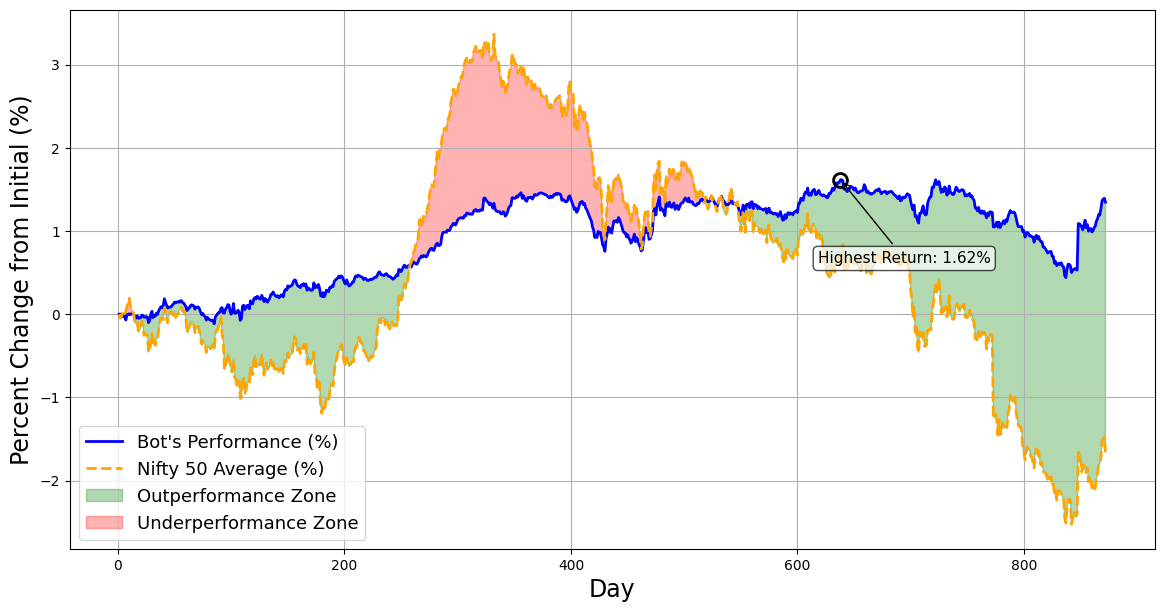

Performance plot successfully saved as 'portfolio_vs_nifty_comparison.png'


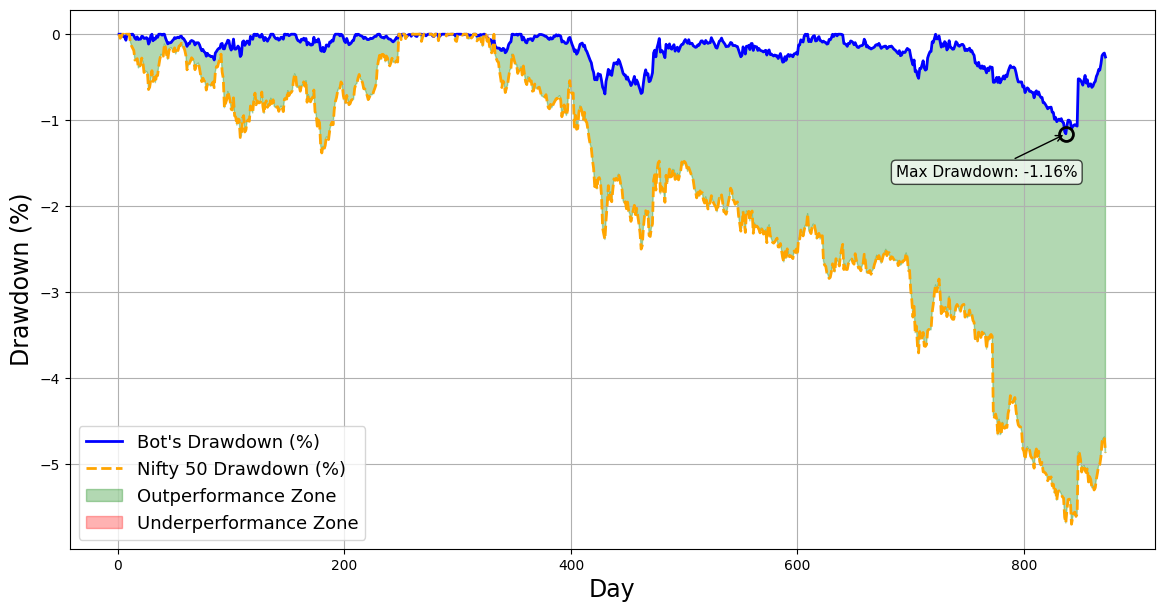

Drawdown plot successfully saved as 'bot_vs_nifty_drawdown.png'


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

combined_portfolio_df = pd.concat(portfolio_df_list, axis=1)

if combined_portfolio_df.index.tz is not None:
    combined_portfolio_df.index = combined_portfolio_df.index.tz_localize(None)

portfolio_cols = [col for col in combined_portfolio_df.columns if col.startswith('Portfolio_')]
combined_portfolio_df['Average_Portfolio'] = combined_portfolio_df[portfolio_cols].mean(axis=1)

close_dfs = []
for ticker, df in all_data.items():
    if not pd.api.types.is_datetime64_any_dtype(df['time']):
        df['time'] = pd.to_datetime(df['time'])
    if df['time'].dt.tz is not None:
        df['time'] = df['time'].dt.tz_localize(None)

    df.set_index('time', inplace=True, drop=False)
    close_dfs.append(df[['Close']].rename(columns={'Close': ticker}))

combined_closes = pd.concat(close_dfs, axis=1).sort_index().ffill().bfill()
combined_closes['Nifty_Average'] = combined_closes.mean(axis=1)

if combined_closes.index.tz is not None:
    combined_closes.index = combined_closes.index.tz_localize(None)

aligned_df = pd.DataFrame({
    'time':             np.array(combined_closes.index)[-combined_portfolio_df['Average_Portfolio'].size:],
    'Average_Portfolio': np.array(combined_portfolio_df['Average_Portfolio'])[-combined_portfolio_df['Average_Portfolio'].size:],
    'Nifty_Average':    np.array(combined_closes['Nifty_Average'])[-combined_portfolio_df['Average_Portfolio'].size:]
})

initial_portfolio_value = 10000
initial_nifty_value     = aligned_df['Nifty_Average'].iloc[0]

bot_percent_change = (
    (aligned_df['Average_Portfolio'] - initial_portfolio_value)
    / initial_portfolio_value
) * 100

nifty_percent_change = (
    (aligned_df['Nifty_Average'] - initial_nifty_value)
    / initial_nifty_value
) * 100

outperformance_mask   = bot_percent_change > nifty_percent_change
underperformance_mask = ~outperformance_mask

plt.figure(figsize=(14, 7))

days = np.arange(1, len(aligned_df) + 1)

plt.plot(days, bot_percent_change,
         label="Bot's Performance (%)",
         color="blue",
         linestyle="-",
         linewidth=2)

plt.plot(days, nifty_percent_change,
         label="Nifty 50 Average (%)",
         color="orange",
         linestyle="--",
         linewidth=2)

plt.fill_between(days,
                 nifty_percent_change,
                 bot_percent_change,
                 where=outperformance_mask,
                 color="green",
                 alpha=0.3,
                 interpolate=True,
                 label="Outperformance Zone")

plt.fill_between(days,
                 nifty_percent_change,
                 bot_percent_change,
                 where=underperformance_mask,
                 color="red",
                 alpha=0.3,
                 interpolate=True,
                 label="Underperformance Zone")

max_return      = bot_percent_change.max()
max_return_day  = bot_percent_change.idxmax()
highest_x_value = days[max_return_day]

plt.plot(highest_x_value, max_return,
         marker='o',
         markersize=10,
         markerfacecolor='none',
         markeredgecolor='black',
         markeredgewidth=2)

plt.annotate(
    f"Highest Return: {max_return:.2f}%",
    xy=(highest_x_value, max_return),
    xytext=(highest_x_value - 20, max_return - 1),
    fontsize=11,
    arrowprops=dict(arrowstyle='->', color='black'),
    bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.7)
)

plt.xlabel("Day", fontsize=17)
plt.ylabel("Percent Change from Initial (%)", fontsize=17)
plt.legend(fontsize=13, loc='lower left')
plt.grid(True)

perf_image_path = "portfolio_vs_nifty_comparison.png"
plt.savefig(perf_image_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Performance plot successfully saved as '{perf_image_path}'")

bot_values   = aligned_df['Average_Portfolio']
nifty_values = aligned_df['Nifty_Average']

bot_cummax   = bot_values.cummax()
nifty_cummax = nifty_values.cummax()

bot_drawdown   = (bot_values / bot_cummax - 1) * 100  # in %
nifty_drawdown = (nifty_values / nifty_cummax - 1) * 100

bot_drawdown   = bot_drawdown.iloc[-combined_portfolio_df['Average_Portfolio'].size:]
nifty_drawdown = nifty_drawdown.iloc[-combined_portfolio_df['Average_Portfolio'].size:]

drawdown_outperform_mask   = bot_drawdown > nifty_drawdown
drawdown_underperform_mask = ~drawdown_outperform_mask

plt.figure(figsize=(14, 7))

plt.plot(days, bot_drawdown,
         label="Bot's Drawdown (%)",
         color="blue",
         linestyle="-",
         linewidth=2)

plt.plot(days, nifty_drawdown,
         label="Nifty 50 Drawdown (%)",
         color="orange",
         linestyle="--",
         linewidth=2)

plt.fill_between(days,
                 nifty_drawdown,
                 bot_drawdown,
                 where=drawdown_outperform_mask,
                 color="green",
                 alpha=0.3,
                 interpolate=True,
                 label="Outperformance Zone")
plt.fill_between(days,
                 nifty_drawdown,
                 bot_drawdown,
                 where=drawdown_underperform_mask,
                 color="red",
                 alpha=0.3,
                 interpolate=True,
                 label="Underperformance Zone")

bot_max_drawdown = bot_drawdown.min()
bot_max_dd_day   = bot_drawdown.idxmin()
bot_dd_x_value   = np.where(bot_drawdown.index == bot_max_dd_day)[0][0] + 1

plt.plot(bot_dd_x_value, bot_max_drawdown,
         marker='o',
         markersize=10,
         markerfacecolor='none',
         markeredgecolor='black',
         markeredgewidth=2)

plt.annotate(
    f"Max Drawdown: {bot_max_drawdown:.2f}%",
    xy=(bot_dd_x_value, bot_max_drawdown),
    xytext=(bot_dd_x_value - 150, bot_max_drawdown - 0.5),
    fontsize=11,
    arrowprops=dict(arrowstyle='->', color='black'),
    bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.7)
)

plt.xlabel("Day", fontsize=17)
plt.ylabel("Drawdown (%)", fontsize=17)
plt.legend(fontsize=13, loc='lower left')
plt.grid(True)

drawdown_image_path = "bot_vs_nifty_drawdown.png"
plt.savefig(drawdown_image_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Drawdown plot successfully saved as '{drawdown_image_path}'")


In [18]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Create the ML artifacts folder if it doesn't exist
ml_artifacts_path = "/content/drive/My Drive/ML_artifacts"
if not os.path.exists(ml_artifacts_path):
  os.makedirs(ml_artifacts_path)

# Move the file
!mv pdt.xlsx /content/drive/My\ Drive/ML_artifacts
!mv bot_vs_nifty_drawdown.png /content/drive/My\ Drive/ML_artifacts
!mv portfolio_vs_nifty_comparison.png /content/drive/My\ Drive/ML_artifacts
!mv thegraph.csv /content/drive/My\ Drive/ML_artifacts
!mv trading_summary.csv

# Verify
!ls /content/drive/My\ Drive/ML_artifacts


Mounted at /content/drive
mv: missing destination file operand after 'trading_summary.csv'
Try 'mv --help' for more information.
bot_vs_nifty_drawdown.png  portfolio_vs_nifty_comparison.png
pdt.xlsx		   thegraph.csv
